# Setup

In [1]:
!pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import gc
import math
import random
from glob import glob
from collections import defaultdict, Counter
from typing import List, Dict
import joblib
import pickle

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

## constants

In [3]:
EXP_NAME = "exp147"
DIR = "/gdrive/MyDrive/amazon_kdd_2023/"
K_FOLDS = 3
SEED = 42
LOCALES = ["IT", "FR", "ES"]

# This parameter controls to which end item the candidate is tied. 
# For example, if [1,2], candidates are generated from the last item and second last item in each session.
LAST_NS = [1, 2, 3] 

In [4]:
# リポジトリ一覧にgcsfuseのものを追加
!echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

# インストール
!apt-get update
!apt-get install gcsfuse

# マウント用のディレクトリを準備
!mkdir -p /content/gcs

# バケットをディレクトリにマウント
!gcsfuse kddcup2023_2 /content/gcs

deb http://packages.cloud.google.com/apt gcsfuse-focal main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  45067      0 --:--:-- --:--:-- --:--:-- 45067
OK
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,011 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5,002 B]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Ign:8 http://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages
Get:9 https://cloud.r-project.org/bin/linux/ubuntu focal

In [5]:
%env DATA_ROOT /content/data

env: DATA_ROOT=/content/data


In [6]:
%env EXP_NAME exp147

env: EXP_NAME=exp147


In [7]:
!mkdir -p ${DATA_ROOT} && \
    cp /content/gcs/train/task2/train_${EXP_NAME}.zip ${DATA_ROOT} && \
    cd ${DATA_ROOT} && \
    unzip -n train_${EXP_NAME}.zip

Archive:  train_exp147.zip
Created by ZIP Extractor v4.50 (https://zipextractor.app)
  inflating: train_chunk_exp147_0    
  inflating: train_chunk_exp147_6    
  inflating: train_chunk_exp147_5    
  inflating: train_chunk_exp147_4    
  inflating: train_chunk_exp147_3    
  inflating: train_chunk_exp147_2    
  inflating: train_chunk_exp147_1    


In [8]:
PARAMS = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "boosting": "gbdt",
    "seed": SEED,
    "num_leaves": 50,
    "max_depth": 10,
    "learning_rate": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
    "min_data_in_leaf": 30,
    "eval_at": [100],
    "lambdarank_truncation_level" : 105,
    "deterministic":True,
}

In [9]:
USE_FEATURES = [
    # === candidate features ===
    "co_visit_weight_last1", "consective_1_weight_last1", "consective_3_weight_last1", "consective_5_weight_last1", "similarity_score_last1", "lift_last1", "nns_similality_last1", "prone_distance_last1",
    "co_visit_weight_last2", "consective_1_weight_last2", "consective_3_weight_last2", "consective_5_weight_last2", "similarity_score_last2", "lift_last2", "nns_similality_last2", "prone_distance_last2",
    "co_visit_weight_last3", "consective_1_weight_last3", "consective_3_weight_last3", "consective_5_weight_last3", "similarity_score_last3", "lift_last3", "nns_similality_last3", "prone_distance_last3",
    "imf_score", "imf_score_to_recent_intereaction_n3", "imf_score_to_recent_intereaction_n2", "imf_score_to_recent_intereaction_n5",
    "co_visit_rank_last1", "consective_1_rank_last1", "consective_3_rank_last1", "consective_5_rank_last1", "similarity_rank_last1", "lift_rank_last1", "nns_rank_last1", "prone_rank_last1",
    "co_visit_rank_last2", "consective_1_rank_last2", "consective_3_rank_last2", "consective_5_rank_last2", "similarity_rank_last2", "lift_rank_last2", "nns_rank_last2", "prone_rank_last2",
    "co_visit_rank_last3", "consective_1_rank_last3", "consective_3_rank_last3", "consective_5_rank_last3", "similarity_rank_last3", "lift_rank_last3", "nns_rank_last3", "prone_rank_last3",
    "imf_rank", "imf_rank_to_recent_intereaction_n3", "imf_rank_to_recent_intereaction_n2", "imf_rank_to_recent_intereaction_n5",
    # === session features ===
    "S_session_length",
    "S_nunique_brand",
    "S_ratio_unique_brand",
    "S_nunique_item",
    "S_ratio_repurchase",
    "S_locale",
    "S_mean_price", "S_max_price", "S_min_price", "S_std_price", "S_total_amount",
    "S_color_not_null_count", "S_size_not_null_count", "S_model_not_null_count", "S_material_not_null_count", "S_author_not_null_count",
    "S_last_item_price",
    # === product features ===
    "P_price", "P_locale_purchase_count", "P_total_locale_amount",
    "P_purchase_count", "P_purchase_count_global",
    "P_total_amount",
    "P_brand_purchase_count", "P_brand_purchase_count_global",
    "P_brand_mean_price", "P_brand_max_price", "P_brand_min_price", "P_brand_std_price", "P_total_brand_amount",
    "P_price_diff_to_avg_brand_price",
    "P_n_unique_locale",
    "P_is_color_null", "P_is_size_null", "P_is_model_null", "P_is_material_null", "P_is_author_null",
    "P_purchase_count_ratio_to_locale", "P_purchase_amount_ratio_to_locale", "P_purchase_count_ratio_to_brand", "P_purchase_amount_ratio_to_brand",
    # === session * product features ===
    "SP_price_diff_to_mean_price", "SP_price_diff_to_min_price", "SP_price_diff_to_max_price", "SP_price_diff_to_last_price",
    "SP_brand_price_diff_to_mean_price", "SP_brand_price_diff_to_min_price", "SP_brand_price_diff_to_max_price", "SP_brand_price_diff_to_last_price",
    # === similality features ===
    "imf_similarity", 
    "graph_emb_similarity_last1", "graph_emb_similarity_last2", "graph_emb_similarity_last3", 
    "i2v_similarity_last1", "i2v_similarity_last2", "i2v_similarity_last3", 
]

## functions

In [10]:
# functions for model training, prediction and evaluation

def train_lgb_model(train:pd.DataFrame) -> np.array:
    feat_imp = np.zeros((len(USE_FEATURES),))
    gkf = GroupKFold(n_splits=K_FOLDS)
    for fold, (train_idx, val_idx) in enumerate(gkf.split(train, train["label"], groups=train["session_id"])):
        print(f'Fold {fold+1}')

        # Split data into train and validation sets
        train_tmp = train.iloc[train_idx].copy()
        valid_tmp = train.iloc[val_idx].copy()
        train_tmp.sort_values("session_id", inplace=True)
        valid_tmp.sort_values("session_id", inplace=True)
        train_baskets = train_tmp.groupby("session_id")["candidate_item"].count().values
        valid_baskets = valid_tmp.groupby("session_id")["candidate_item"].count().values
        X_train, y_train = train_tmp[USE_FEATURES], train_tmp["label"]
        X_val, y_val = valid_tmp[USE_FEATURES], valid_tmp["label"]

        # Create LightGBM dataset
        lgb_train = lgb.Dataset(X_train, y_train, group=train_baskets)
        lgb_val = lgb.Dataset(X_val, y_val, group=valid_baskets, reference=lgb_train)

        del train_tmp, valid_tmp, X_train, y_train, train_baskets, X_val, y_val, valid_baskets
        gc.collect()

        # Train LightGBM model
        model = lgb.train(PARAMS,
                        lgb_train,
                        num_boost_round=10000,
                        valid_sets=[lgb_train, lgb_val],
                        callbacks=[
                            lgb.early_stopping(stopping_rounds=50),
                            lgb.log_evaluation(100),
                        ]
                )
        
        # Save LightGBM model
        joblib.dump(model, f'/content/gcs/model/task2/{EXP_NAME}_{fold+1}.pkl')

        # Add feature importance scores
        feat_imp += model.feature_importance(importance_type="gain")

    return feat_imp

## fix seed

In [11]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(SEED)

# Train and Inference

## train model

In [12]:
files = glob(f"/content/data/train_chunk_{EXP_NAME}_*")
train = pd.DataFrame()
for f in tqdm(files):
    if len(train) == 0:
        train = pd.read_parquet(f)
    else:
        train = pd.concat([train, pd.read_parquet(f)])

100%|██████████| 7/7 [01:33<00:00, 13.39s/it]


In [13]:
train.head()

,next_item,locale,session_id,last_item_1,last_item_2,last_item_3,candidate_item,co_visit_weight_last1,co_visit_rank_last1,consective_1_weight_last1,...,SP_brand_price_diff_to_min_price,SP_brand_price_diff_to_max_price,SP_brand_price_diff_to_last_price,imf_similarity,i2v_similarity_last1,graph_emb_similarity_last1,i2v_similarity_last2,graph_emb_similarity_last2,i2v_similarity_last3,graph_emb_similarity_last3
0,B0BCJHQC75,IT,train_206608,B0BCKC4RZD,B07TTHHWTF,B09H2YTDV1,B0BCJHQC75,7.980000,6,2,...,6.488333,1.148333,0.000000,0.289130,0.988735,0.997456,0.972124,0.998982,0.981048,0.998701
1,B09XGZJSVZ,IT,train_206609,B09XGR9761,B09XGPHCG6,B09XGVV5X1,B09XGZJSVZ,7.570000,4,2,...,0.323194,-0.476806,-0.476806,0.284655,0.969767,0.914400,0.975976,0.924665,0.973225,0.897113
2,B0B81HH722,IT,train_206610,B08RZCJM6Z,B08RZCJM6Z,None,B0B81HH722,122.959999,1,34,...,7.703871,7.703871,7.703871,0.366260,0.967046,0.993654,0.967046,0.993654,-1.000000,-1.000000
3,B00TKE3JKA,IT,train_206611,B01618WO9O,B01BJQ2060,B01BJQ35WI,B00TKE3JKA,0.250000,10,0,...,19.561510,17.761509,17.761509,0.227829,0.951551,0.910232,0.934420,0.888656,0.951531,0.918053
4,B07Q833RCB,IT,train_206612,B07Q5SYP2N,B094J8TNDB,None,B07Q833RCB,43.000000,2,13,...,1.750000,-0.250000,-0.250000,0.294739,0.983704,0.984322,0.926353,0.973670,-1.000000,-1.000000


Fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.521427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18712
[LightGBM] [Info] Number of data points in the train set: 27828798, number of used features: 112
Training until validation scores don't improve for 50 rounds
[100]	training's ndcg@100: 0.748714	valid_1's ndcg@100: 0.743499
[200]	training's ndcg@100: 0.758967	valid_1's ndcg@100: 0.746254
[300]	training's ndcg@100: 0.767071	valid_1's ndcg@100: 0.747274
[400]	training's ndcg@100: 0.774348	valid_1's ndcg@100: 0.748054
[500]	training's ndcg@100: 0.779975	valid_1's ndcg@100: 0.748263
Early stopping, best iteration is:
[471]	training's ndcg@100: 0.778548	valid_1's ndcg@100: 0.748329
Fold 2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.225675 seconds.
You can set `force_row_wise=true

[Text(0.5, 1.0, 'Feature Importance TOP25')]

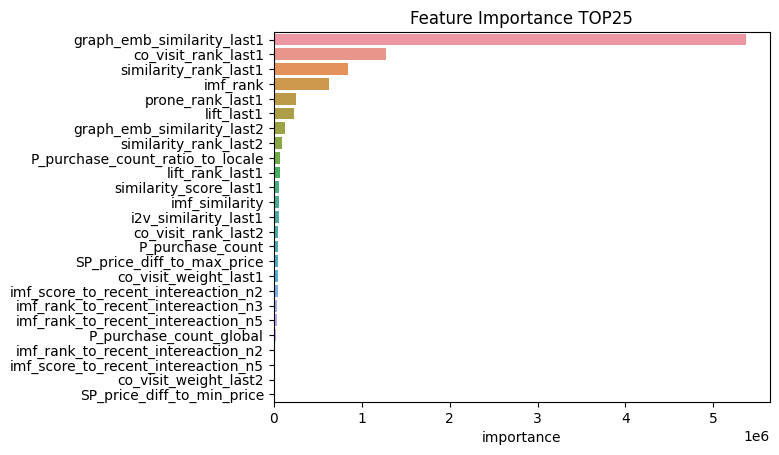

In [14]:
%%time
# train lgbm model
feat_imp = train_lgb_model(train)

# visualize feature importances
fi_df = pd.DataFrame(index=USE_FEATURES)
fi_df["importance"] = feat_imp / K_FOLDS
fi_df = fi_df.sort_values(by="importance", ascending=False).head(25)
sns.barplot(x="importance", y=fi_df.index, data=fi_df).set(title="Feature Importance TOP25")